# Inference: Hamiltonian MCMC

This example shows you how to perform Bayesian inference on a Normal distribution and a time-series problem, using [Hamiltonian Monte Carlo](http://pints.readthedocs.io/en/latest/mcmc_samplers/hamiltonian_mcmc.html).


First, we create a simple normal distribution

In [ ]:
import pints
import pints.toy
import numpy as np
import matplotlib.pyplot as plt

# Create log pdf
log_pdf = pints.toy.NormalLogPDF([5, 5], [[4, -1], [1, 3]])

# Contour plot of pdf
levels = np.linspace(-3,12,20)
num_points = 100
x = np.linspace(-5, 15, num_points)
y = np.linspace(-5, 15, num_points)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
Z = np.exp([[log_pdf([i, j]) for i in x] for j in y])
plt.contour(X, Y, Z)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Now we set up and run a sampling routine using Hamiltonian MCMC

In [ ]:
# Choose starting points for 3 mcmc chains
xs = [
    [-5, -5],
    [3, 3],
    [18, 18],
]

# Set a standard deviation, to give the method a sense of scale
sigma = [1, 1]

# Create mcmc routine
mcmc = pints.MCMCSampling(log_pdf, 3, xs, sigma, method=pints.HamiltonianMCMC)

# Add stopping criterion
mcmc.set_max_iterations(1000)

# Set up modest logging
mcmc.set_log_to_screen(True)
mcmc.set_log_rate(100)

# Update step sizes used by individual samplers
for sampler in mcmc.samplers():
    sampler.set_leapfrog_step_size(0.2)

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

In [ ]:
import pints.plot

# Show traces and histograms
pints.plot.trace(chains)

# Discard warm up
chains = chains[:, 500:, :]

In [ ]:
# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(chains))

# Look at distribution in chain 0
pints.plot.pairwise(chains[0], kde=True)

# Show graphs
plt.show()

It seems Hamiltonian MCMC does very well at this problem!

## Hamiltonian MCMC on a time-series problem

We now try the same method on a time-series problem

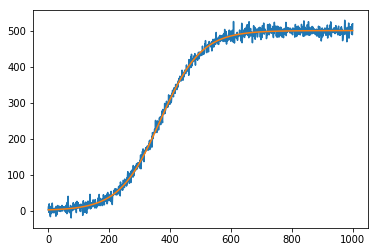

In [9]:
from __future__ import print_function
import pints
import pints.toy as toy
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

class Model(pints.ForwardModel):
    def __init__(self):
        self.model = toy.LogisticModel()
    def simulate(self, x, times):
        return self.model.simulate([x[0], 500], times)
    def simulateS1(self, x, times):
        return self.model.simulateS1([x[0], 500], times)
    def n_parameters(self):
        return 1

# Load a forward model
model = Model()
    
# Create some toy data
real_parameters = np.array([0.015])
times = np.linspace(0, 1000, 1000)
org_values = model.simulate(real_parameters, times)

# Add noise
noise = 10
values = org_values + np.random.normal(0, noise, org_values.shape)

plt.figure()
plt.plot(times, values)
plt.plot(times, org_values)
plt.show()



In [10]:

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create a log-likelihood function
log_likelihood = pints.KnownNoiseLogLikelihood(problem, noise)

print(log_likelihood.evaluateS1(real_parameters))
print(log_likelihood.evaluateS1(real_parameters * 1.001))

ValueError: cannot reshape array of size 2000 into shape (1000,1,1)

In [ ]:
# Create a uniform prior over the parameters
log_prior = pints.UniformLogPrior(
    [0.01, 400],
    [0.02, 600]
)

# Create a posterior log-likelihood (log(likelihood * prior))
#log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Choose starting points for 3 mcmc chains
xs = [
    real_parameters * 1.001,
    #real_parameters * 0.9,
    #real_parameters * 1.15,
]

# Choose a covariance matrix for the proposal step
sigma0 = np.abs(real_parameters) * 0.01

# Create mcmc routine
mcmc = pints.MCMCSampling(
        log_likelihood, len(xs), xs, sigma0, method=pints.HamiltonianMCMC)

# Add stopping criterion
mcmc.set_max_iterations(1000)

# Set up modest logging
mcmc.set_log_to_screen(True)
mcmc.set_log_rate(100)

# Set small step size
for sampler in mcmc.samplers():
    sampler.set_leapfrog_step_size(0.01)

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

# Show traces and histograms
pints.plot.trace(chains)

# Discard warm up
chains = chains[:, 500]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(chains))

# Look at distribution in chain 0
pints.plot.pairwise(chains[0])

# Show graphs
plt.show()